# 라이브러리

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 준비

In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/번천/dataset/train_data.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/번천/dataset/test_data.csv')

In [ ]:
raw_data.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [ ]:
raw_data['type'].value_counts()

0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
Name: type, dtype: int64

In [ ]:
raw_test['type'].value_counts()

0    1296
1    1107
2    1098
3     918
4     918
5     747
6     747
7     558
Name: type, dtype: int64

In [ ]:
## 공기압축기가 돌아가는 순서로 열 새롭게 구성

train_data = raw_data[['air_inflow', 'motor_current','motor_rpm', 'motor_temp', 'motor_vibe', 'out_pressure', 'air_end_temp', 'type']].copy()
test_data = raw_test[['air_inflow', 'motor_current','motor_rpm', 'motor_temp', 'motor_vibe', 'out_pressure', 'air_end_temp', 'type']].copy()

설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)

설비 번호 1: 20HP

설비 번호 2: 10HP

설비 번호 3: 50HP

In [ ]:
hp30 = [0, 4, 5, 6, 7]
hp20 = [1]
hp10 = [2]
hp50 = [3]

In [ ]:
# 설비별 데이터 세트 분리

train_data_30hp = train_data[train_data['type'].isin(hp30)].copy()
train_data_20hp = train_data[train_data['type'].isin(hp20)].copy()
train_data_10hp = train_data[train_data['type'].isin(hp10)].copy()
train_data_50hp = train_data[train_data['type'].isin(hp50)].copy()

In [ ]:
# 설비별 데이터 세트 분리

test_data_30hp = test_data[test_data['type'].isin(hp30)].copy()
test_data_20hp = test_data[test_data['type'].isin(hp20)].copy()
test_data_10hp = test_data[test_data['type'].isin(hp10)].copy()
test_data_50hp = test_data[test_data['type'].isin(hp50)].copy()

# 모델 생성과 함수 설정

In [ ]:
# # define the autoencoder network model
# def autoencoder_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(16, activation='relu', return_sequences=True, 
#               kernel_regularizer=regularizers.l2(0.00))(inputs)
#     L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
#     L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)    
#     model = Model(inputs=inputs, outputs=output)
#     return model

In [ ]:
# 모델 구조
timesteps = 7
n_features = 1
layer_1 = 64
layer_2 = 32

# seed 고정
seed = 123

In [ ]:
class lstm_ae(tf.keras.Model):
  def __init__(self, timesteps, n_features, layer_1, layer_2):
    super(lstm_ae).__init__()
    self.n_features = n_features
    self.timesteps = timesteps
    self.layer_1 = layer_1
    self.layer_2 = layer_2


  def encoder(self, x):
    x = layers.LSTM(self.layer_1, activation = 'relu', return_sequences = True)(x)
    x = layers.LSTM(self.layer_2, activation = 'relu', return_sequences = False)(x)
    en_output = layers.RepeatVector(self.timesteps)(x)
    return en_output

  def decoder(self, x):
    x = layers.LSTM(self.layer_2, activation = 'relu', return_sequences = True)(x)
    x = layers.LSTM(self.layer_1, activation = 'relu', return_sequences = True)(x)
    de_output = layers.TimeDistributed(layers.Dense(self.n_features))(x)

    return de_output

  def build(self):
    inputs = Input(shape = (self.timesteps, self.n_features))
    encoder = self.encoder(inputs)
    decoder = self.decoder(encoder)

    return Model(inputs, decoder)

In [ ]:
# lstm 구조에 맞게 데이터 변형하는 함수

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [ ]:
## 평행 좌표 그리는 함수

def parallel(for_view, num):
  parallel_coordinates(frame = for_view[for_view['type'].isin(num)], class_column = 'type', colormap = plt.get_cmap('Set1'));

In [ ]:
## 모델 평가를 위해 3차원을 2차원으로 줄임

def flatten(X):
    flattened_X = X.reshape(X.shape[0], -1)
    return flattened_X

In [ ]:
## timestep 3 이기 때문에 처음 두 개의 데이터에 대한 가정

def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)

# 경로 설정

In [ ]:
# 현재 폴더 경로 지정
PATH = '/content/drive/MyDrive/번천/모델 7'
os.chdir(PATH)
os.getcwd()

'/content/drive/MyDrive/번천/모델 7'

# hp30

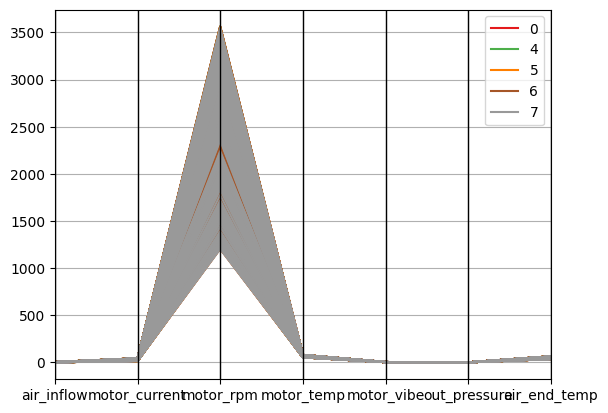

In [ ]:
parallel(train_data, hp30)

## 첫 번째 모델

In [134]:
## 모델 학습을 위해 데이터 준비

scaler_30hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화


full_data_30hp = pd.concat([test_data_30hp, train_data_30hp], ignore_index = True)
scaler_30hp.fit(full_data_30hp.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))
train_scale_30hp = scaler_30hp.transform(train_data_30hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_30hp = slicing(test_scale_30hp,1).reshape(-1, 7 ,1)
train_slice_30hp = slicing(train_scale_30hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_30hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/30hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_30hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./30hp_history.npy',history.history)

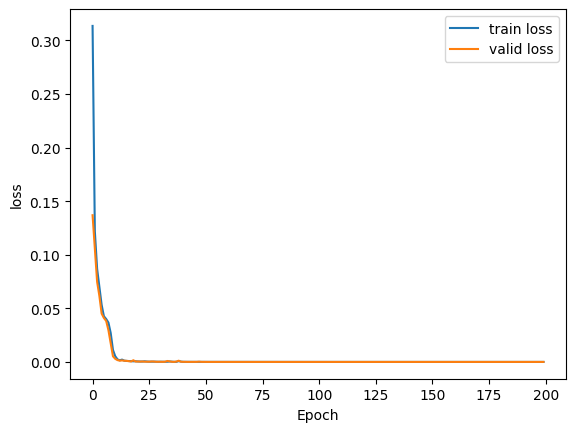

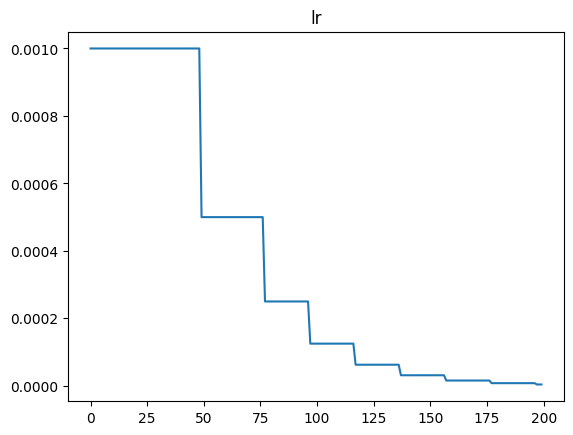

In [135]:
# 저장한 model과 history 불러오기
lstm_ae_30hp = load_model('./모델 저장/30hp.h5')
history = history=np.load('./30hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [136]:
# 역치 계산
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)

# 계산한 역치로 이상 판단
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )
anom_30hp = test_mse_30hp > threshold_30hp

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

134/134 [==============================] - 1s 5ms/step
291


(0.0, 0.003)

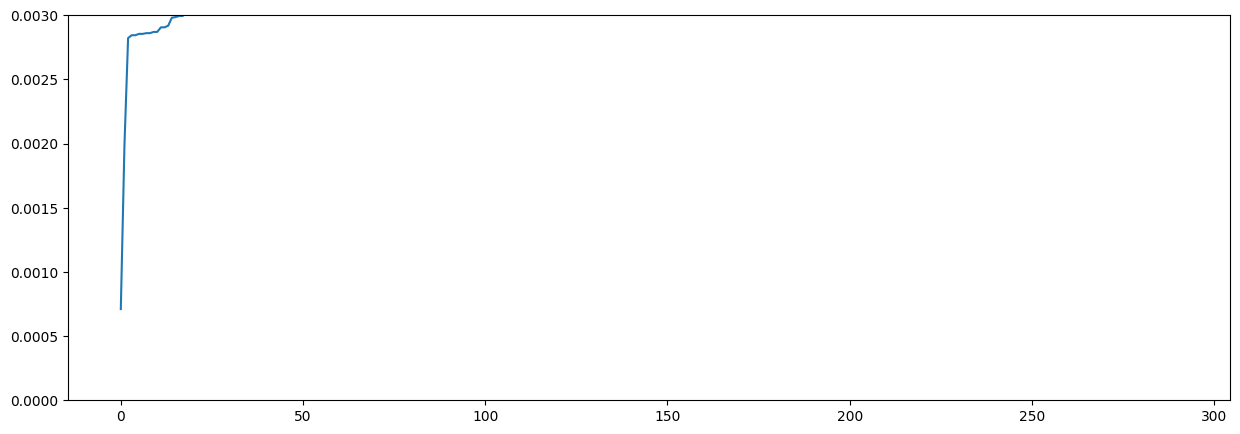

In [ ]:
plt.figure(figsize = (15,5));
plt.plot(np.sort(test_mse_30hp)[-291:])
plt.ylim(0,0.003)

In [98]:
anom_30hp = test_mse_30hp > np.sort(test_mse_30hp)[-291]

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

290


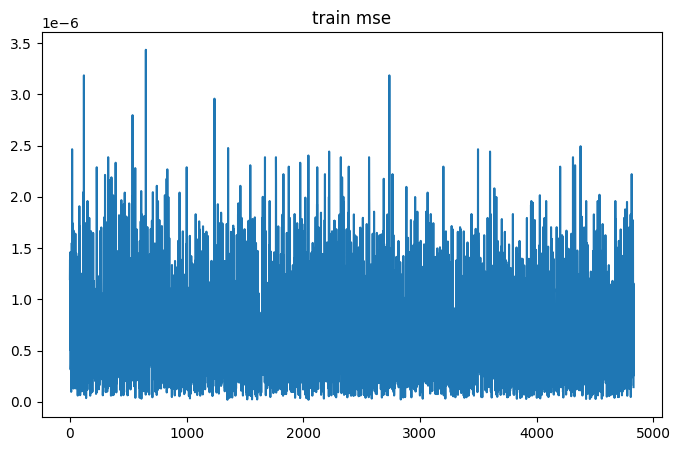

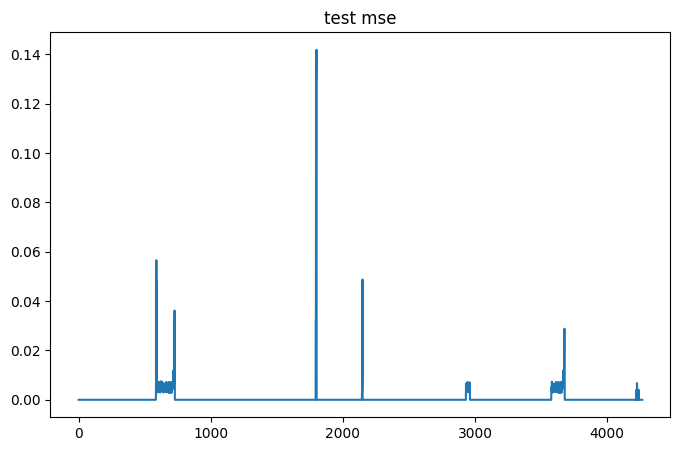

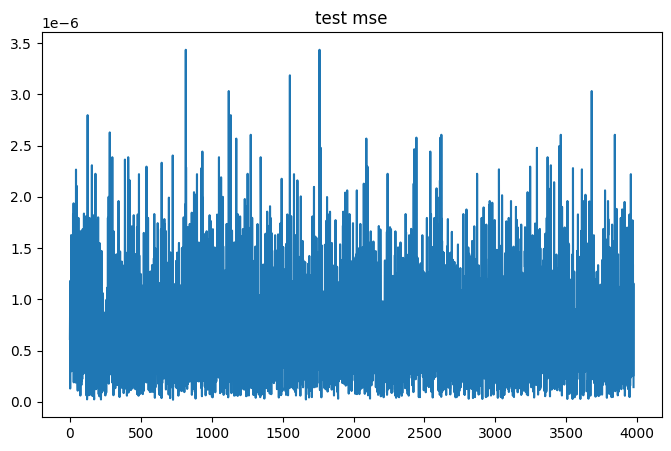

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_30hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp[~anom_30hp]);
plt.title('test mse');

## 두 번째 모델

In [ ]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_30hp = test_data_30hp[test_mse_30hp < (np.mean(train_mse_30hp) + np.std(train_mse_30hp))].copy()
new_train_30hp = pd.concat([train_data_30hp, for_new_train_30hp], ignore_index = True) 

In [ ]:
new_train_30hp

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
0,1.59,20.53,1680.0,58.67,2.93,0.7,41.00,0
1,2.97,38.40,3142.0,74.91,3.75,0.7,59.28,0
2,1.91,24.73,2023.0,62.48,3.12,0.7,45.29,0
3,2.37,30.63,2506.0,67.84,3.39,0.7,51.33,0
4,1.90,24.65,2017.0,62.41,3.12,0.7,45.21,0
...,...,...,...,...,...,...,...,...
4827,1.47,19.04,1558.0,57.31,2.87,0.7,39.48,7
4828,1.48,19.19,1570.0,57.44,2.87,0.7,39.63,7
4829,1.56,20.15,1649.0,58.32,2.92,0.7,40.61,7
4830,1.59,20.52,1679.0,58.66,2.93,0.7,40.99,7


In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_30hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_30hp = pd.concat([test_data_30hp, train_data_30hp], ignore_index = True)
scaler_30hp.fit(full_data_30hp.drop(['type'], axis=1))
train_scale_30hp = scaler_30hp.transform(new_train_30hp.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_30hp = slicing(test_scale_30hp,1).reshape(-1, 7 ,1)
train_slice_30hp = slicing(train_scale_30hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_30hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/30hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_30hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/30hp_history.npy',history.history)

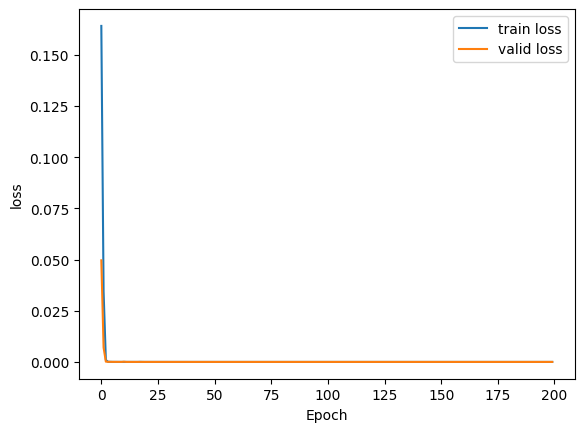

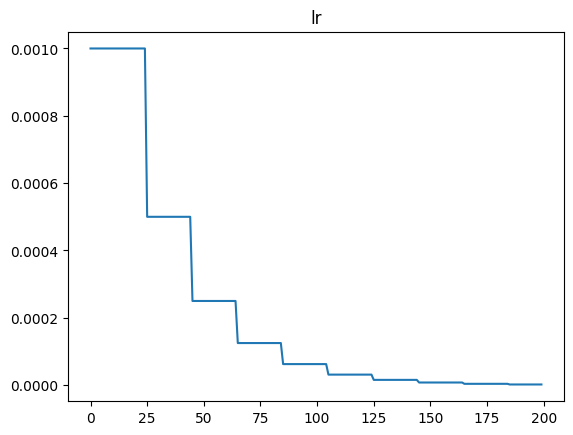

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_30hp = load_model('./모델 저장2/30hp.h5')
history = history=np.load('./history2/30hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)

# 계산한 역치로 이상 판단
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )
anom_30hp = test_mse_30hp > threshold_30hp

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

134/134 [==============================] - 1s 5ms/step
291


In [ ]:
anom_30hp = test_mse_30hp > np.mean(train_mse_30hp) + 10*np.std(train_mse_30hp)

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

325


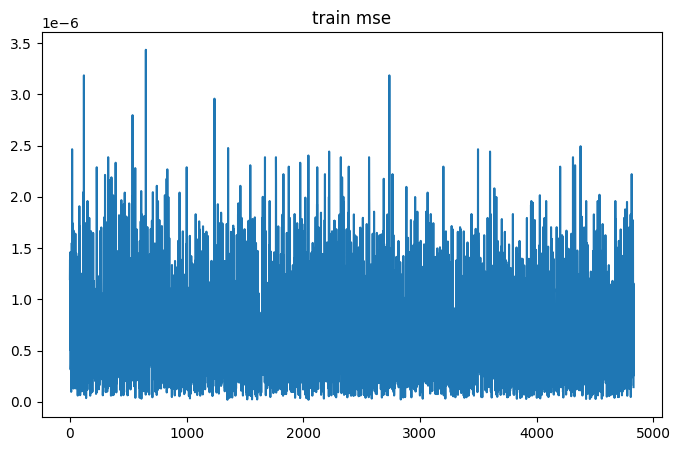

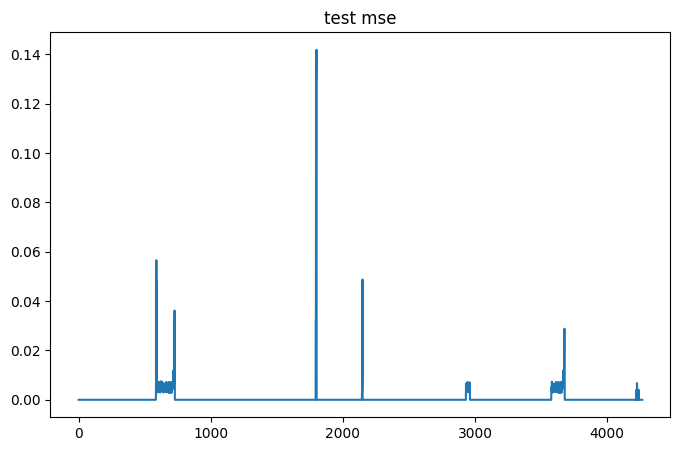

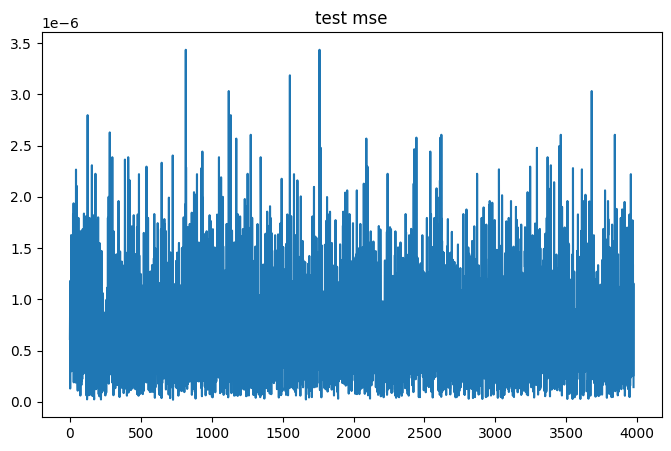

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_30hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp[~anom_30hp]);
plt.title('test mse');

# hp20

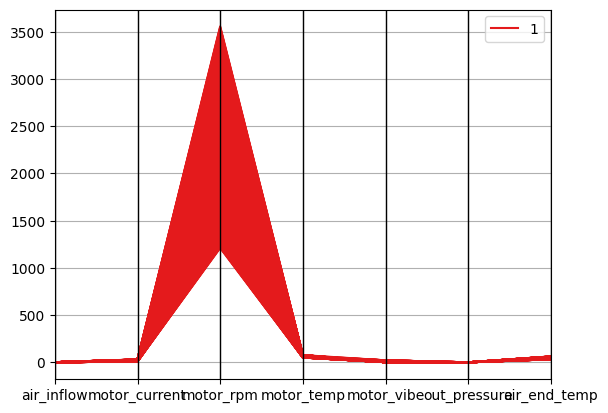

In [ ]:
parallel(train_data, hp20)

## 첫 번째 모델

In [137]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_20hp = pd.concat([test_data_20hp, train_data_20hp], ignore_index = True)
scaler_20hp.fit(full_data_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(train_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./20hp_history.npy',history.history)

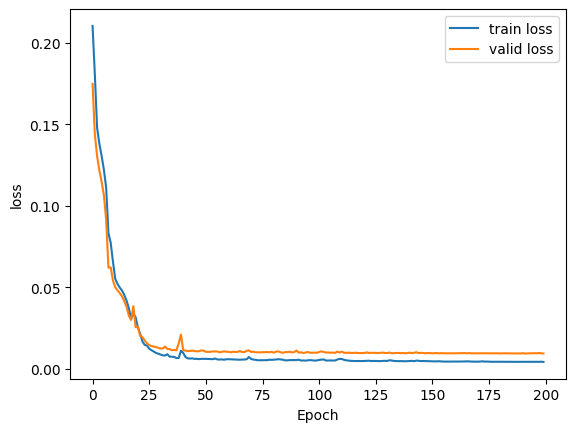

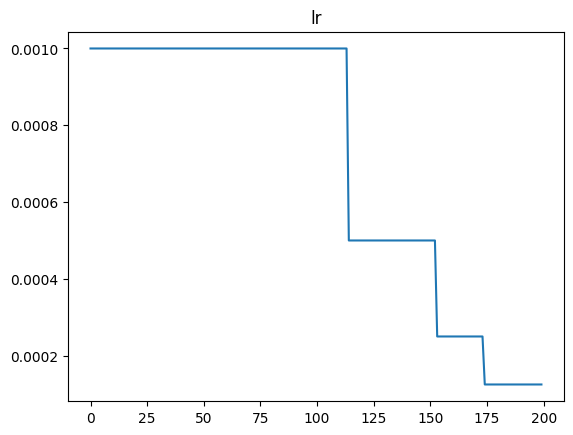

In [111]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장/20hp.h5')
history = history=np.load('./20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [112]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 5ms/step
0


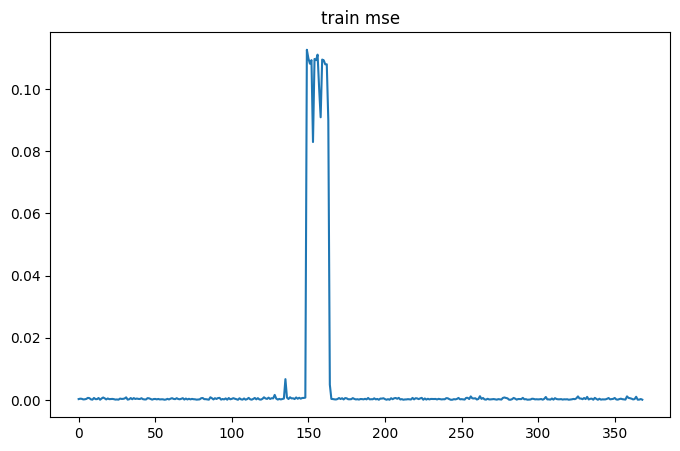

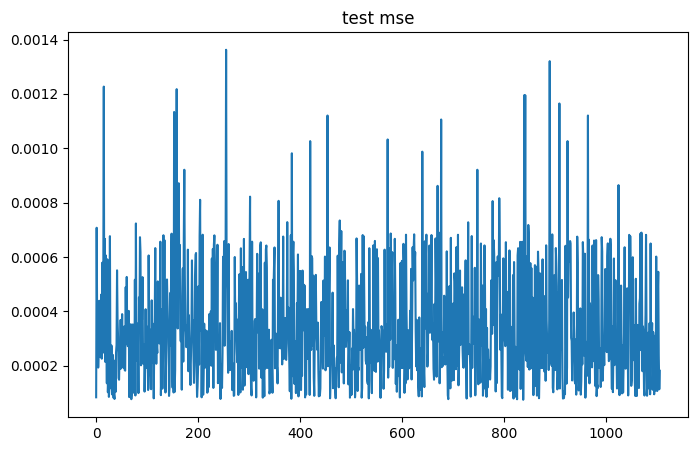

In [113]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
# plt.ylim(0,0.0014)
plt.title('train mse');


# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

## 두 번째 모델

In [120]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용


train_cut_20hp = train_data_20hp[train_mse_20hp < np.max(test_mse_20hp)].copy()
train_cut_20hp
# for_new_train_20hp = test_data_20hp[test_mse_20hp < (np.mean(train_mse_20hp) + np.std(train_mse_20hp))].copy()
# new_train_20hp = pd.concat([train_data_20hp, for_new_train_20hp], ignore_index = True) 

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
432,1.73,25.60,2973.0,71.03,3.45,0.7,55.16,1
433,1.31,19.32,2244.0,62.93,3.05,0.7,46.05,1
434,1.33,19.69,2287.0,63.41,3.07,0.7,46.59,1
435,1.87,27.56,3200.0,73.56,3.58,0.7,58.00,1
436,1.68,24.78,2878.0,69.98,3.40,0.7,53.98,1
...,...,...,...,...,...,...,...,...
796,0.72,10.56,1226.0,51.62,2.48,0.7,33.33,1
797,0.86,12.68,1473.0,54.37,2.62,0.7,36.41,1
798,0.83,12.31,1430.0,53.89,2.59,0.7,35.88,1
799,1.77,26.07,3028.0,71.64,3.48,0.7,55.85,1


In [121]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_20hp = pd.concat([test_data_20hp, train_data_20hp], ignore_index = True)
scaler_20hp.fit(full_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(train_cut_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [122]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/20hp_history.npy',history.history)

Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 0.2061
Epoch 1: val_loss improved from inf to 0.16654, saving model to ./모델 저장2/20hp.h5
10/10 [==============================] - 8s 110ms/step - loss: 0.2061 - val_loss: 0.1665 - lr: 0.0010
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.1790
Epoch 2: val_loss improved from 0.16654 to 0.13558, saving model to ./모델 저장2/20hp.h5
10/10 [==============================] - 0s 35ms/step - loss: 0.1790 - val_loss: 0.1356 - lr: 0.0010
Epoch 3/200
 9/10 [==========================>...] - ETA: 0s - loss: 0.1474
Epoch 3: val_loss improved from 0.13558 to 0.12507, saving model to ./모델 저장2/20hp.h5
10/10 [==============================] - 0s 35ms/step - loss: 0.1452 - val_loss: 0.1251 - lr: 0.0010
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.1355
Epoch 4: val_loss improved from 0.12507 to 0.11518, saving model to ./모델 저장2/20hp.h5
10/10 [=========================

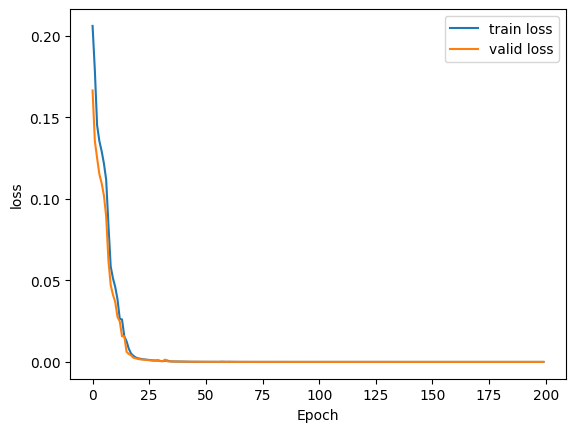

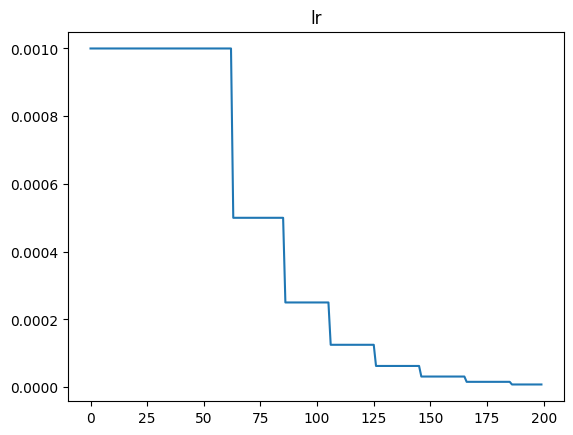

In [123]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장2/20hp.h5')
history = history=np.load('./history2/20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [124]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 7ms/step
0


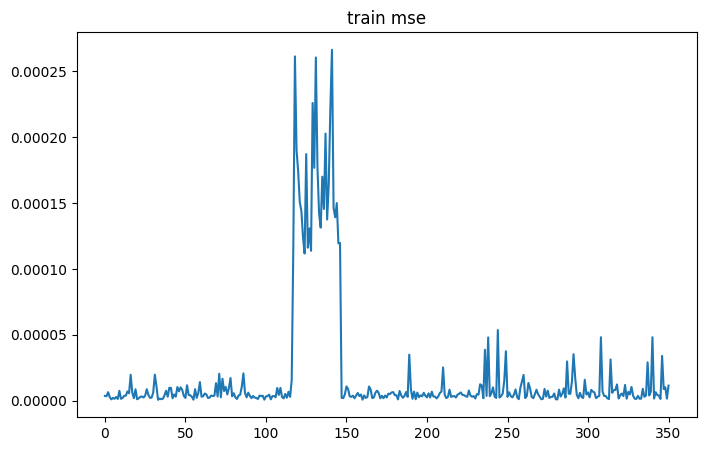

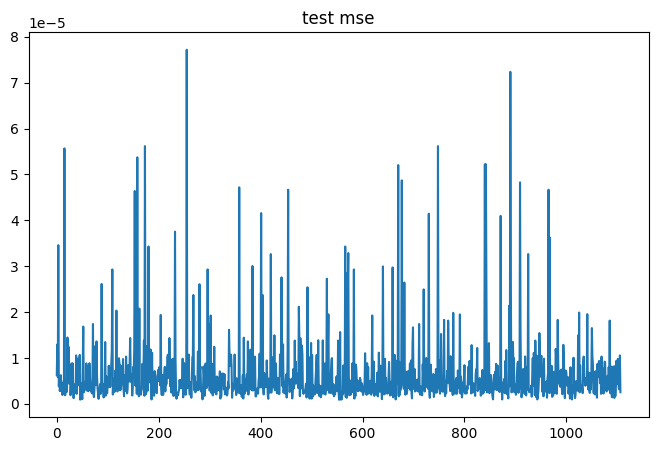

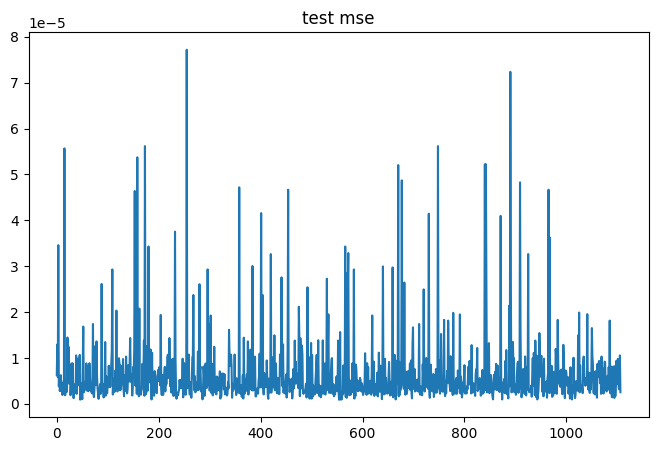

In [125]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp[~anom_20hp]);
plt.title('test mse');

## 세 번째 모델

In [128]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용


train_cut2_20hp = train_cut_20hp[train_mse_20hp < np.max(test_mse_20hp)].copy()
train_cut2_20hp
# for_new_train_20hp = test_data_20hp[test_mse_20hp < (np.mean(train_mse_20hp) + np.std(train_mse_20hp))].copy()
# new_train_20hp = pd.concat([train_data_20hp, for_new_train_20hp], ignore_index = True) 

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
432,1.73,25.60,2973.0,71.03,3.45,0.7,55.16,1
433,1.31,19.32,2244.0,62.93,3.05,0.7,46.05,1
434,1.33,19.69,2287.0,63.41,3.07,0.7,46.59,1
435,1.87,27.56,3200.0,73.56,3.58,0.7,58.00,1
436,1.68,24.78,2878.0,69.98,3.40,0.7,53.98,1
...,...,...,...,...,...,...,...,...
796,0.72,10.56,1226.0,51.62,2.48,0.7,33.33,1
797,0.86,12.68,1473.0,54.37,2.62,0.7,36.41,1
798,0.83,12.31,1430.0,53.89,2.59,0.7,35.88,1
799,1.77,26.07,3028.0,71.64,3.48,0.7,55.85,1


In [129]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_20hp = pd.concat([test_data_20hp, train_data_20hp], ignore_index = True)
scaler_20hp.fit(full_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(train_cut2_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [130]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장3/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history3/20hp_history.npy',history.history)

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 0.2039
Epoch 1: val_loss improved from inf to 0.16352, saving model to ./모델 저장3/20hp.h5
9/9 [==============================] - 6s 112ms/step - loss: 0.2039 - val_loss: 0.1635 - lr: 0.0010
Epoch 2/200
7/9 [======================>.......] - ETA: 0s - loss: 0.1869
Epoch 2: val_loss improved from 0.16352 to 0.13504, saving model to ./모델 저장3/20hp.h5
9/9 [==============================] - 0s 34ms/step - loss: 0.1753 - val_loss: 0.1350 - lr: 0.0010
Epoch 3/200
8/9 [=========================>....] - ETA: 0s - loss: 0.1444
Epoch 3: val_loss improved from 0.13504 to 0.12253, saving model to ./모델 저장3/20hp.h5
9/9 [==============================] - 0s 30ms/step - loss: 0.1437 - val_loss: 0.1225 - lr: 0.0010
Epoch 4/200
8/9 [=========================>....] - ETA: 0s - loss: 0.1362
Epoch 4: val_loss improved from 0.12253 to 0.11447, saving model to ./모델 저장3/20hp.h5
9/9 [==============================] - 0s 30ms

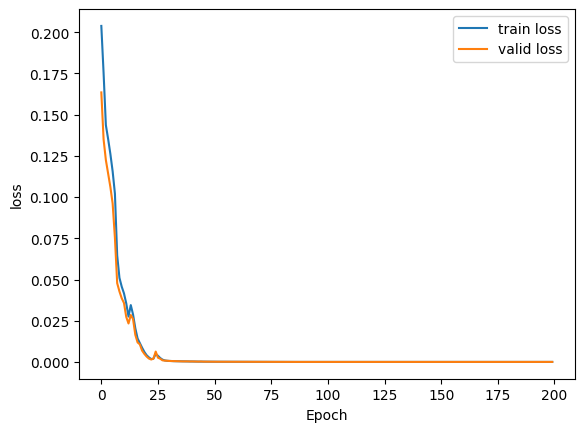

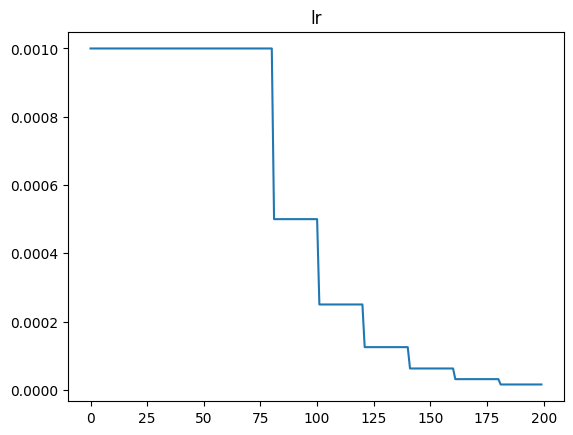

In [131]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장3/20hp.h5')
history = history=np.load('./history3/20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [132]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 6ms/step
4


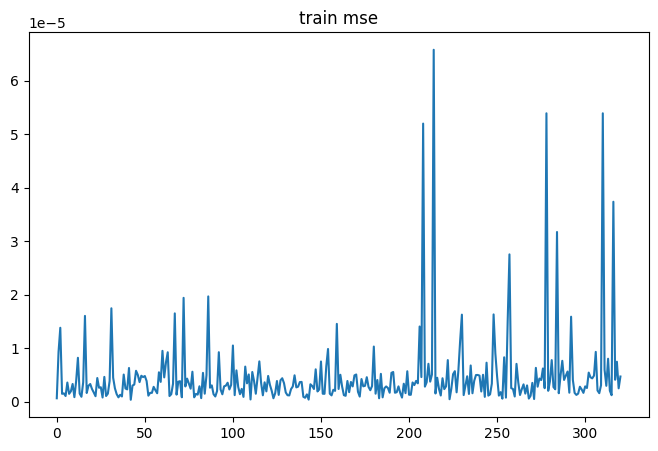

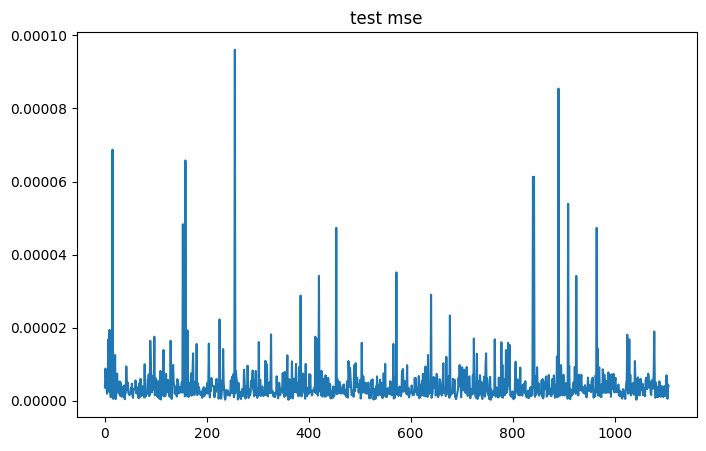

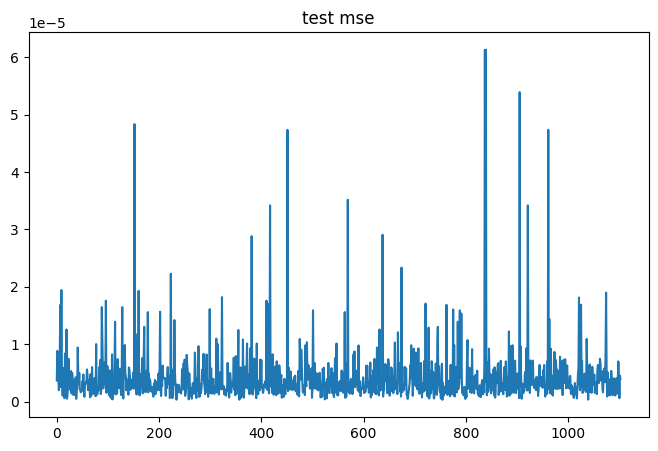

In [133]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp[~anom_20hp]);
plt.title('test mse');

# hp10


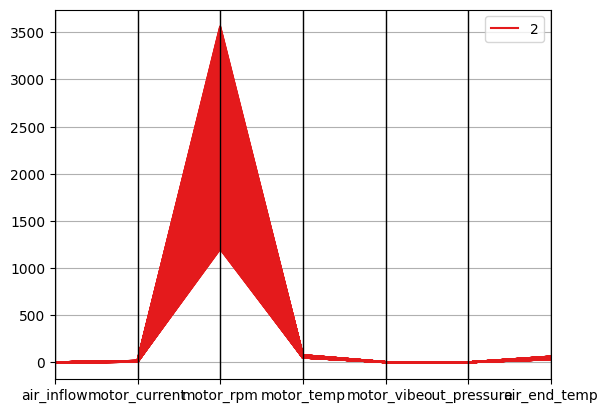

In [ ]:
parallel(train_data, hp10)

In [138]:
## 모델 학습을 위해 데이터 준비

scaler_10hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_10hp = pd.concat([test_data_10hp, train_data_10hp], ignore_index = True)
scaler_10hp.fit(full_data_10hp.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))
train_scale_10hp = scaler_10hp.transform(train_data_10hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_10hp = slicing(test_scale_10hp,1).reshape(-1, 7 ,1)
train_slice_10hp = slicing(train_scale_10hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_10hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/10hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_10hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./10hp_history.npy',history.history)

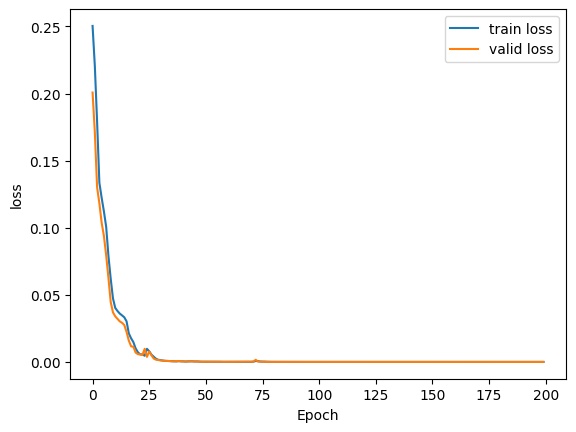

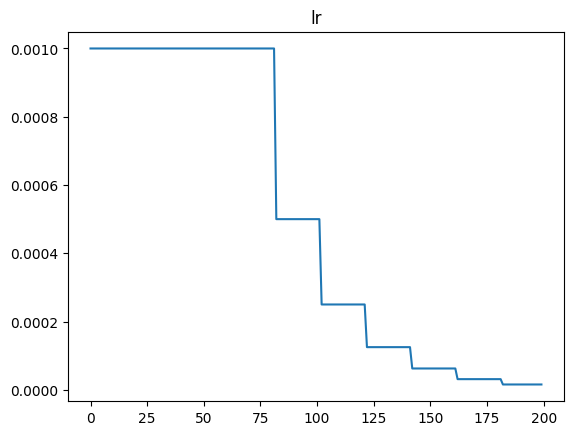

In [139]:
# 저장한 model과 history 불러오기
lstm_ae_10hp = load_model('./모델 저장/10hp.h5')
history = history=np.load('./10hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [140]:
# 역치 계산
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)

# 계산한 역치로 이상 판단
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )
anom_10hp = test_mse_10hp > threshold_10hp

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

35/35 [==============================] - 0s 5ms/step
27


In [ ]:
anom_10hp = test_mse_10hp > np.mean(train_mse_10hp) + 100*np.std(train_mse_10hp)

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

21


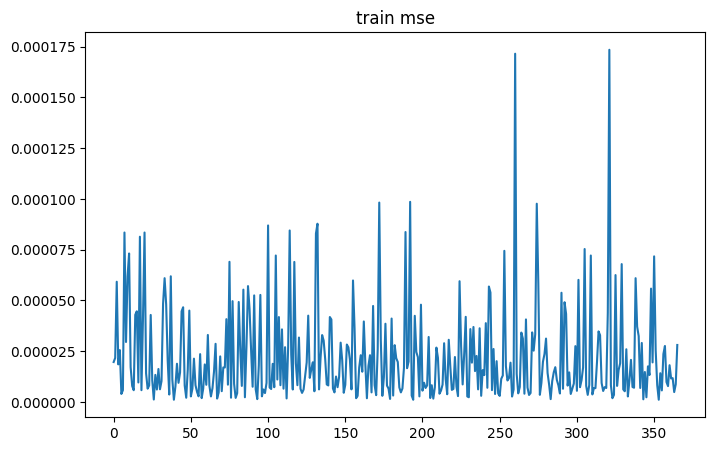

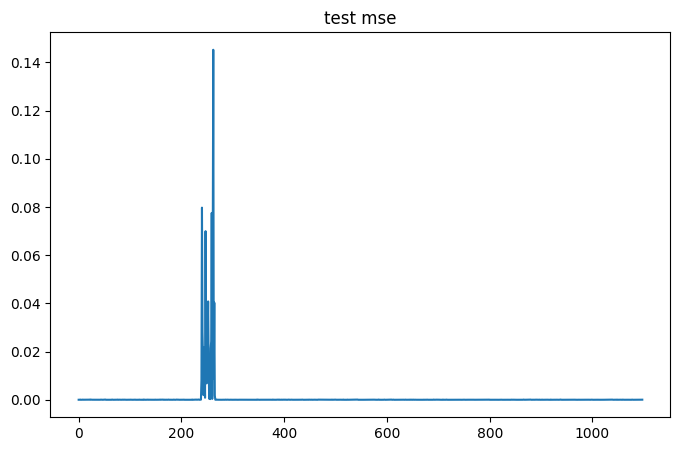

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_10hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp);
plt.title('test mse');

## 두 번째 모델

In [ ]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_10hp = test_data_10hp[test_mse_10hp < (np.mean(train_mse_10hp) + np.std(train_mse_10hp))].copy()
new_train_10hp = pd.concat([train_data_10hp, for_new_train_10hp], ignore_index = True) 

In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_10hp = MinMaxScaler()

# 설비 라벨 제외하여 train data로 정규화
train_scale_10hp = scaler_10hp.fit_transform(new_train_10hp.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_10hp = slicing(test_scale_10hp,1).reshape(-1, 7 ,1)
train_slice_10hp = slicing(train_scale_10hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_10hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/10hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_10hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/10hp_history.npy',history.history)

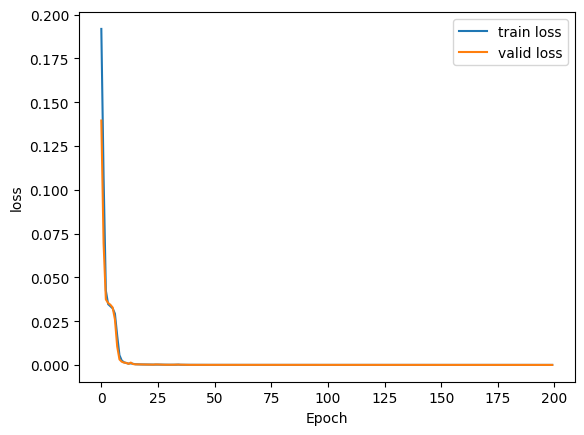

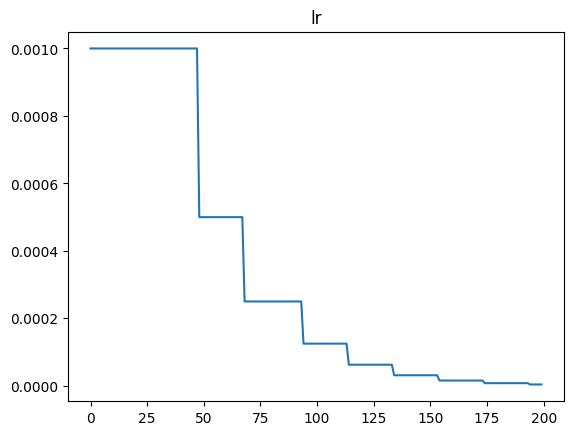

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_10hp = load_model('./모델 저장2/10hp.h5')
history = history=np.load('./history2/10hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)

# 계산한 역치로 이상 판단
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )
anom_10hp = test_mse_10hp > threshold_10hp

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

35/35 [==============================] - 0s 3ms/step
27


In [ ]:
anom_10hp = test_mse_10hp > np.mean(train_mse_10hp) + 10*np.std(train_mse_10hp)

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

27


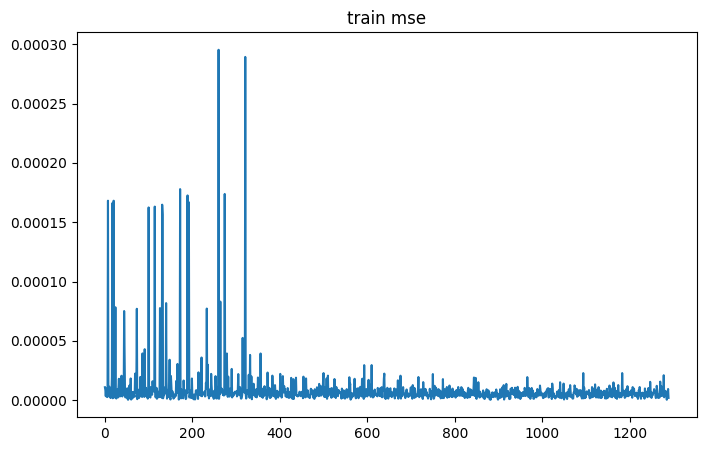

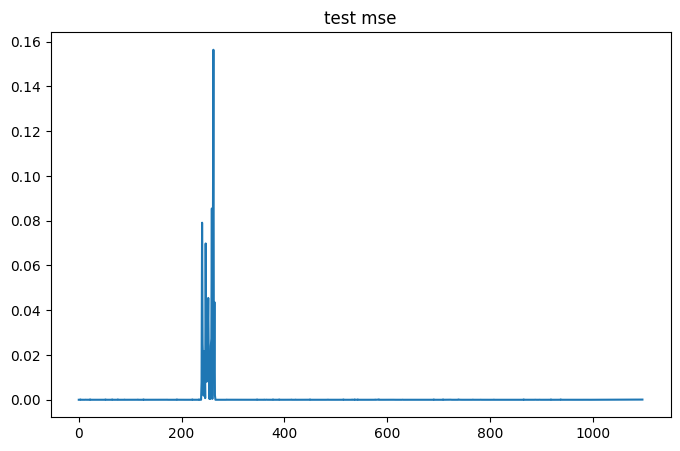

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_10hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp);
plt.title('test mse');

# hp50

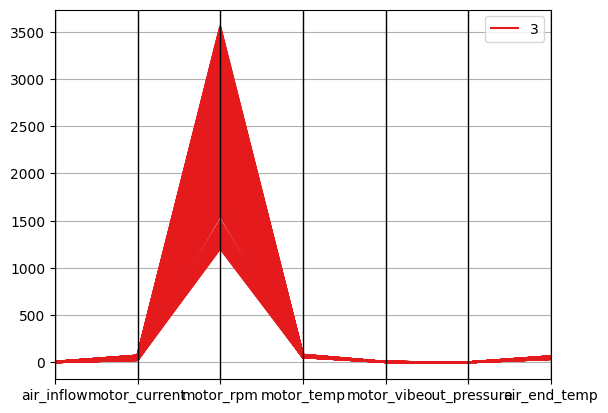

In [ ]:
parallel(train_data, hp50)

In [141]:
## 모델 학습을 위해 데이터 준비

scaler_50hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_50hp = pd.concat([test_data_50hp, train_data_50hp], ignore_index = True)
scaler_50hp.fit(full_data_50hp.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))
train_scale_50hp = scaler_50hp.transform(train_data_50hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_50hp = slicing(test_scale_50hp,1).reshape(-1, 7 ,1)
train_slice_50hp = slicing(train_scale_50hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_50hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/50hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_50hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./50hp_history.npy',history.history)

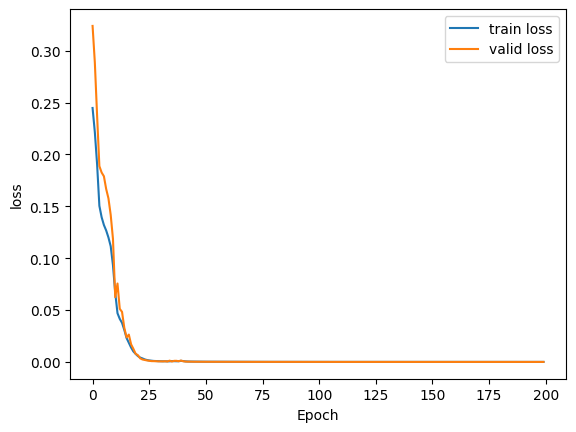

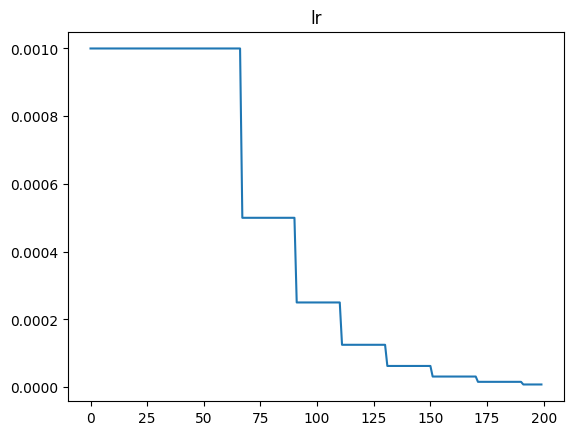

In [142]:
# 저장한 model과 history 불러오기
lstm_ae_50hp = load_model('./모델 저장/50hp.h5')
history = history=np.load('./50hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [143]:
# 역치 계산
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)

# 계산한 역치로 이상 판단
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )
anom_50hp = test_mse_50hp > threshold_50hp

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

29/29 [==============================] - 0s 5ms/step
27


In [ ]:
anom_50hp = test_mse_50hp > np.mean(train_mse_50hp) + 100*np.std(train_mse_50hp)

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

25


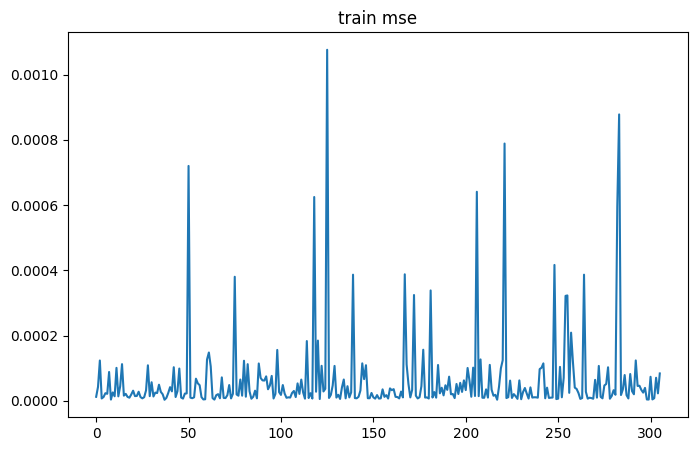

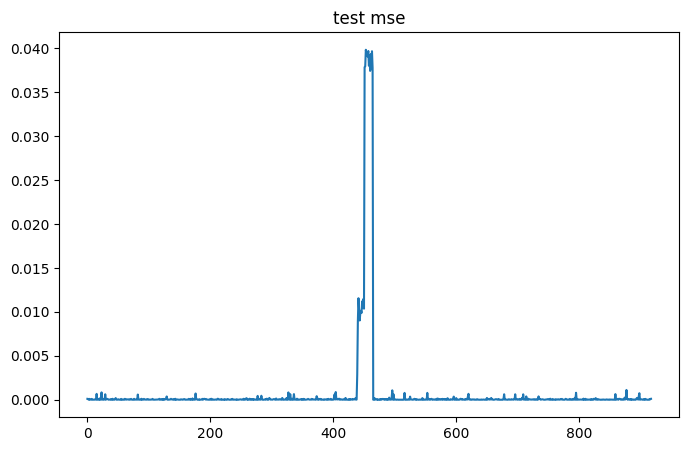

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_50hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp);
plt.title('test mse');

## 두 번째 모델

In [ ]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_50hp = test_data_50hp[test_mse_50hp < (np.mean(train_mse_50hp) + np.std(train_mse_50hp))].copy()
new_train_50hp = pd.concat([train_data_50hp, for_new_train_50hp], ignore_index = True) 

In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_50hp = MinMaxScaler()

# 설비 라벨 제외하여 train data로 정규화
train_scale_50hp = scaler_50hp.fit_transform(new_train_50hp.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_50hp = slicing(test_scale_50hp,1).reshape(-1, 7 ,1)
train_slice_50hp = slicing(train_scale_50hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_50hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/50hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_50hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/50hp_history.npy',history.history)

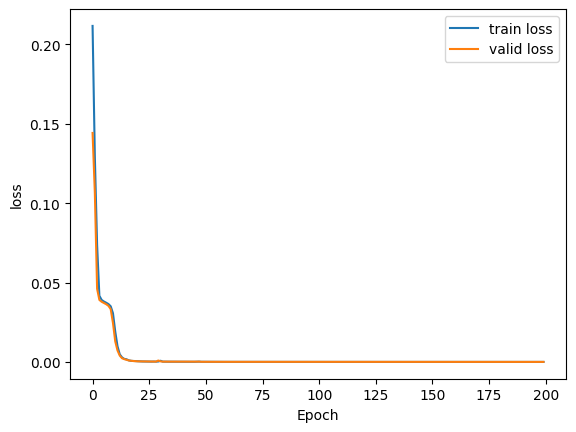

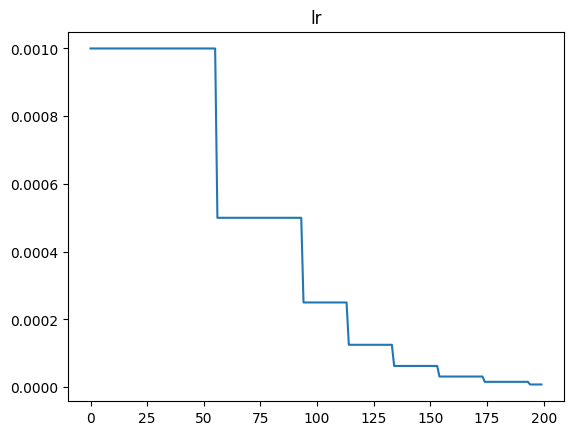

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_50hp = load_model('./모델 저장2/50hp.h5')
history = history=np.load('./history2/50hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)

# 계산한 역치로 이상 판단
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )
anom_50hp = test_mse_50hp > threshold_50hp

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

29/29 [==============================] - 0s 4ms/step
27


In [ ]:
anom_50hp = test_mse_50hp > np.mean(train_mse_50hp) + 10*np.std(train_mse_50hp)

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

34


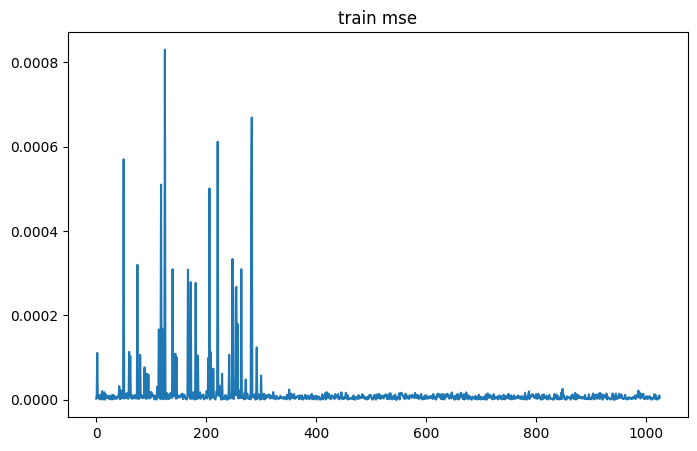

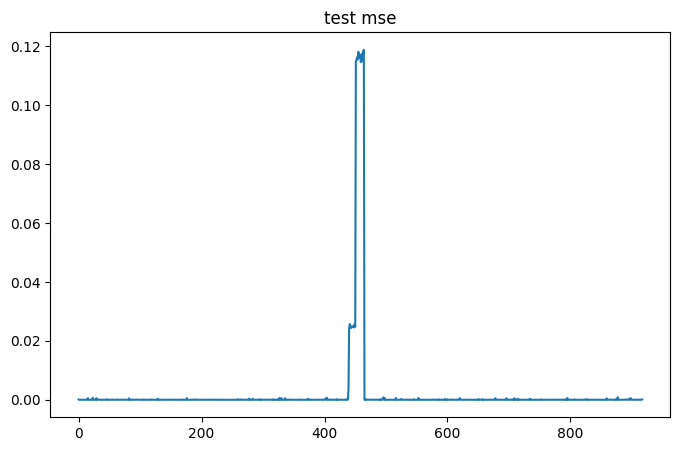

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_50hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp);
plt.title('test mse');

# pred 합치기

test_data_30hp

test_data_20hp

test_data_10hp

test_data_50hp

In [144]:
answer = pd.concat([pred_30hp['y'], pred_20hp['y'], pred_10hp['y'], pred_50hp['y']]).sort_index()
answer = pd.concat([test_data['type'], answer], axis=1)
answer.rename(columns={'y':'label'}, inplace = True)

In [ ]:
answer

,type,label
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False
...,...,...
7384,7,False
7385,7,False
7386,7,False
7387,7,False


In [145]:
answer.to_csv("/content/drive/MyDrive/번천/answer/answer_model_7_2272.csv")